In [1]:
import jax
import jax.numpy as jnp
import optax
from jax import random, grad, value_and_grad
from jax import nn

import numpy as np
import os
import dill

from lib.lib_Adam_tanh import (
    Functions,
    AdamTrain
)

from lib.plot_lib import (
    PlotResults,
    plot_loss
)

PR = PlotResults(Functions)

print(jax.devices())
print(jnp.sin(jnp.pi/2))

%load_ext autoreload
%autoreload 2

[CudaDevice(id=0)]
1.0


In [2]:
data_name = 'SPY'
training_data = np.load(f"training_data/{data_name}.npz")

diff_type = "diagonal"
trajectory_step_size = 1
trajectories = training_data["trajectories"]
D = trajectories.shape[1]

print(trajectories.shape)

(1, 1, 8182)


In [3]:
# ex_name = "ex4-3D_spd"

# # load true functions
# with open(f"true_functions/{ex_name}.pkl", "rb") as f:
#     true_functions = dill.load(f)

# true_drift = true_functions["drift"]
# true_diffusion = true_functions["diffusion"]

# # load data
# data_name = f"{ex_name}_time0.01_SS0.01_ntraj10000"
# training_data = np.load(f"training_data/{data_name}.npz")

# diff_type = str(training_data["diff_type"])
# trajectory_step_size = training_data["step_size"]
# trajectories = training_data["trajectories"]
# D = trajectories.shape[1]

# print(trajectories.shape)

In [4]:
# subsample data
h = 1
sampled_trajectories = trajectories[:, :, ::int(h/trajectory_step_size)]

x_data = sampled_trajectories[:, :, :-1].reshape(-1, D)
y_data = sampled_trajectories[:, :, 1:].reshape(-1, D)

#step_sizes = np.zeros((x_data.shape[0], 1)) + step_size

key = random.PRNGKey(0)

print(x_data.shape)


(8181, 1)


In [5]:
pretrain = False

if pretrain:
    # load pretrained network
    ARFF_data = np.load(f"saved_results/param/{data_name}_ARFF_trig.npz", allow_pickle=True)
    # unwrap the dict, keep complex dtype
    drift_param = {k: jnp.array(v) for k, v in ARFF_data["drift_param"].item().items()}
    diff_param  = {k: jnp.array(v) for k, v in ARFF_data["diff_param"].item().items()}
    
    # # apply cauchy schwarz sqrt approximation
    # diff_param["amp"] = jnp.sqrt(diff_param["amp"].astype(jnp.complex64))
    # diff_param["omega"] = (diff_param["omega"] / 2.0).astype(jnp.complex64)

else:
    # create network
    K = 2**7
    if diff_type == "diagonal":
        a = D
    else:
        a = int(D*(D+1)/2)
    
    
    # # --- Define drift NN (f_theta) ---
    # def init_drift_params(key):
    #     k1, k2 = random.split(key)
    #     return {
    #         "omega": random.normal(k1, (D, K)) * 0.01,
    #         "amp": random.normal(k2, (2*K, D)) * 0.01
    #     }
    
    # # --- Define diffusion NN (sigma_theta') that outputs lower-triangular matrix ---
    # def init_diffusion_params(key):
    #     k1, k2 = random.split(key)
    #     return {
    #         "omega": random.normal(k1, (D, K)) * 0.01,
    #         "amp": random.normal(k2, (2*K, a)) * 0.01
    #     }

    
    def glorot_uniform(key, shape):
        fan_in, fan_out = shape[0], shape[1]
        limit = jnp.sqrt(6.0 / (fan_in + fan_out))
        return random.uniform(key, shape, minval=-limit, maxval=limit, dtype=jnp.float64)
    
    def init_drift_params(key):
        k1, k2, k3, k4 = random.split(key, 4)
        return {
            "W1": glorot_uniform(k1, (D, K)),    # input → hidden
            "b1": jnp.zeros((K,), dtype=jnp.float64),
            "W2": glorot_uniform(k2, (K, D)),    # hidden → output
            "b2": jnp.zeros((D,), dtype=jnp.float64),
            "amp": jnp.zeros((1, a))
        }
    
    def small_uniform(key, shape):
        return random.uniform(key, shape, minval=-1e-2, maxval=1e-2, dtype=jnp.float64)
    
    def init_diffusion_params(key):
        k1, k2, k3, k4 = random.split(key, 4)
        return {
            "W1": small_uniform(k1, (D, K)),
            "b1": small_uniform(k2, (K,)),
            "W2": small_uniform(k3, (K, a)),
            "b2": small_uniform(k4, (a,)),
            "amp": jnp.zeros((1, a))
        }


    # --- Initialize ---
    key1, key2, key3 = random.split(key, 3)
    drift_param = init_drift_params(key1)
    diff_param = init_diffusion_params(key2)



In [6]:
print(AdamTrain.nll_loss(drift_param, diff_param, x_data, y_data, h, diff_type))

5.384762391669579


In [7]:
hyperparams = {"epochs": 1000, "learning_rate": 1e-5, "batch_size": 2**5}
Adam_drift_param, Adam_diff_param, times, losses, val_losses = AdamTrain.training_loop(hyperparams, drift_param, diff_param, x_data, y_data, h, diff_type, val_split=0.1)


epoch 999: loss = 0.8582, val_loss = 3.21369


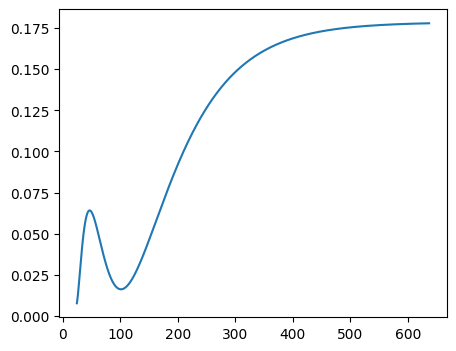

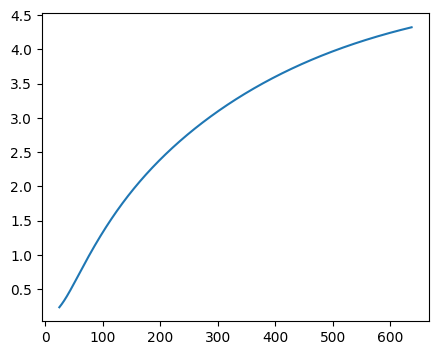

[[-0.11760363  0.16919596  0.13963804  0.19611384  0.07843042  0.27391291
  -0.11342942  0.01529952 -0.25508712 -0.06601813  0.10002821  0.03249376
  -0.14209838 -0.1944053  -0.14675396  0.26189359 -0.07536133 -0.12349195
  -0.08865785 -0.23440173  0.22573297 -0.00561799  0.02459013  0.08218617
   0.0912563   0.02323243 -0.00558574  0.14349917  0.12731045  0.02569329
  -0.07450794 -0.14890618 -0.1080696  -0.22756415 -0.00553228 -0.14349519
   0.00555358 -0.1787169   0.0403158   0.04031228  0.15216018 -0.00562033
  -0.08299048  0.11721233 -0.08212179  0.09756344 -0.13150765  0.114979
  -0.06251115 -0.08238589 -0.08174696 -0.21615215 -0.00560609  0.11939186
   0.0163658   0.08883318  0.09656733  0.22390475 -0.0167458   0.12154915
  -0.21375622  0.08694936 -0.28715938 -0.03232784  0.09128937  0.10572224
  -0.07668221  0.00617959 -0.14916207 -0.10741799 -0.09813977 -0.11710605
   0.14913395 -0.00558479  0.21003476  0.17469934  0.01605565  0.20960037
   0.19734479 -0.01233909  0.04521022  0

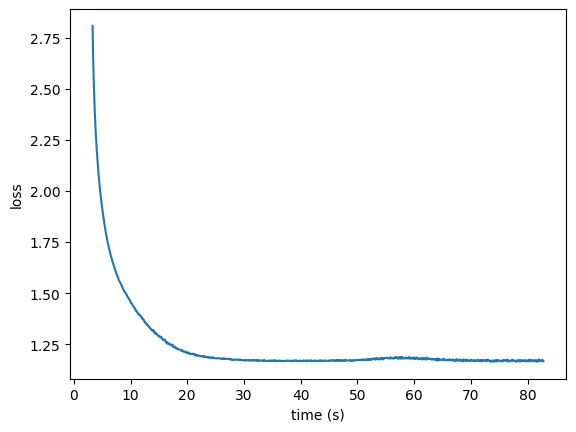

In [8]:
PR.plot_train_v_true(Adam_drift_param, x_data)
PR.plot_train_v_true(Adam_diff_param, x_data, diff_type=diff_type)
plot_loss(times, np.log(val_losses))
print(Adam_drift_param["W1"], Adam_drift_param["b1"], Adam_drift_param["W2"], Adam_drift_param["b2"])

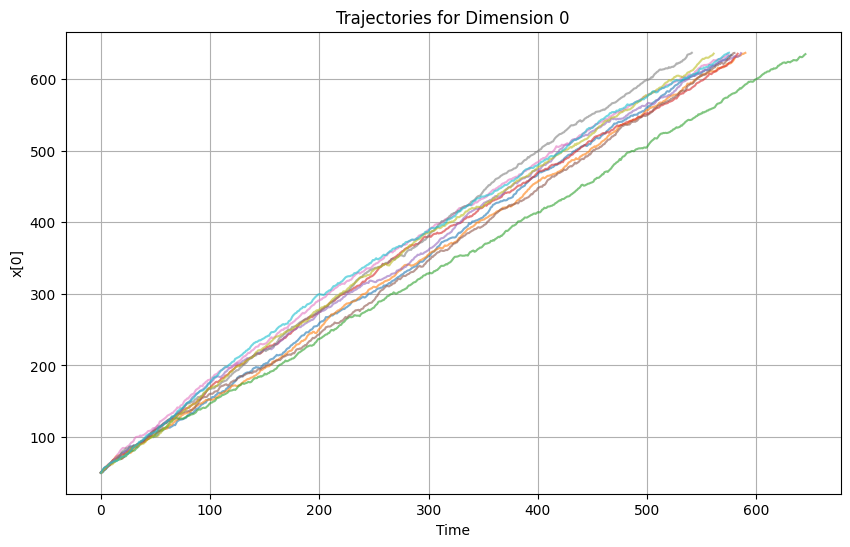

Array([[[50.        , 50.12343973, 50.79094498, ...,         nan,
                 nan,         nan]],

       [[50.        , 52.49212186, 54.11994163, ...,         nan,
                 nan,         nan]],

       [[50.        , 51.8171135 , 52.65192324, ...,         nan,
                 nan,         nan]],

       ...,

       [[50.        , 52.31785415, 53.93430217, ...,         nan,
                 nan,         nan]],

       [[50.        , 50.09863195, 53.00835852, ...,         nan,
                 nan,         nan]],

       [[50.        , 52.24786567, 54.87173466, ...,         nan,
                 nan,         nan]]], dtype=float64)

In [10]:
x_domain = np.array([[50, 50]])
xlim = np.array([[min(x_data), max(x_data)]])

n_trajectories = 10
trajectory_time = 3918
step_size = 1

PR.plot_trajectories(drift_param, diff_param, x_domain, xlim, n_trajectories, trajectory_time, h, diff_type)

In [11]:
# if pretrain:
#     times += ARFF_data["times"]
np.savez(f"saved_results/param/{data_name}_Adam.npz", drift_param=Adam_drift_param, diff_param=Adam_diff_param, diff_type=diff_type, times=times, losses=losses, val_losses=val_losses)